# 01: Sampling

This notebook locates and samples plots, exporting an HDF5 dataset with LiDAR metrics and arrays of NAIP reflectance values for each plot.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ee
import rasterio
import pandas as pd
from openlocationcode import openlocationcode

from naip_cnn import sampling
from naip_cnn.config import BANDS

ee.Authenticate()
ee.Initialize()

In [3]:
N_SAMPLES = 30_000
MIN_SPACING = 100
FOOTPRINT_SIZE = (30, 30)
NAIP_YEAR = 2011

## Generate Sample Points

Our training data will be a set of points with 1) aggregated LiDAR attributes for prediction and 2) corresponding reflectance values from NAIP imagery. Points will be generated from the LiDAR data using a random subset of plots on a regularly spaced grid to ensure a minimum spacing.

Note: If we wanted to extract additional LiDAR metrics, we could simply add them below.

In [4]:
with rasterio.open("../data/Malheur_lidar_cancov.tif") as src:
    cancov = src.read(1)
    lidar_samples = sampling.generate_spaced_samples(
        raster=src, min_spacing=MIN_SPACING, n=N_SAMPLES
    )
    lidar_samples = sampling.extract_raster_at_points(
        raster=src, points=lidar_samples
    ).rename(columns={"b1": "cancov"})

We can compare the distribution of measured and sampled canopy cover values:

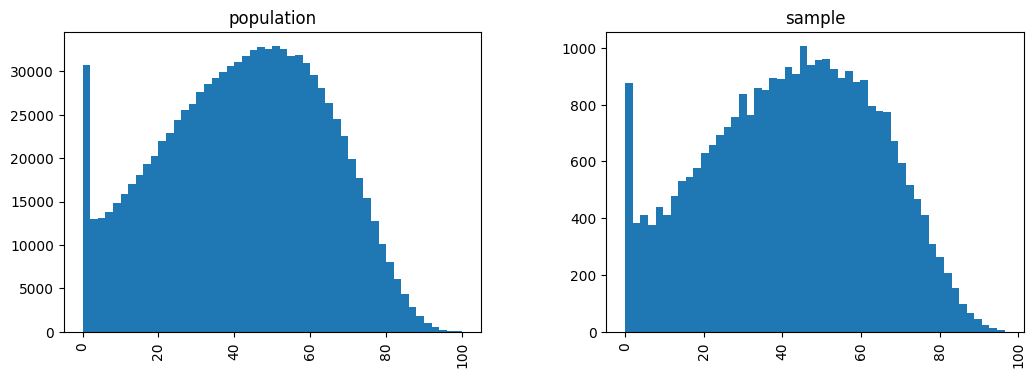

In [5]:
distribution = pd.concat(
    [
        lidar_samples[["cancov"]].assign(group="sample"),
        pd.DataFrame({"cancov": filter(lambda v: v == v, cancov.ravel())}).assign(
            group="population"
        ),
    ]
)

distribution.hist(by="group", bins=50, figsize=(12, 4));

We need a deterministic method for uniquely identifying our sample points so that we can potentially extract additional data in the future. We'll use [Plus Codes](https://maps.google.com/pluscodes/), which encode latitude and longitude coordinates into short strings.

In [6]:
lidar_samples["id"] = lidar_samples.to_crs("EPSG:4326").geometry.apply(
    lambda geom: openlocationcode.encode(geom.y, geom.x, 14)
)
lidar_samples.head()

,geometry,cancov,id
0,POINT (-1831085.934 2621735.394),59.588501,85P2HM28+MH8J9F
1,POINT (-1777085.934 2606835.394),84.616501,85P3G9QF+5437HJ
2,POINT (-1799885.934 2620235.394),48.072300,85P3J343+F72973
3,POINT (-1823485.934 2616135.394),65.647797,85P2GQ9G+QJGJ3M
4,POINT (-1789685.934 2631635.394),45.598701,85P3P4GV+XH824J


## Extract NAIP Chips

With our sample points defined, we can extract spectral data from the NAIP footprint overlapping each. First, we'll create a mosaic of NAIP imagery from the target year, covering our sample points.

In [7]:
proj = ee.Projection(src.crs.to_wkt())
bbox = ee.Geometry.BBox(*lidar_samples.to_crs("EPSG:4326").total_bounds)

naip_mosaic = (
    ee.ImageCollection("USDA/NAIP/DOQQ")
    .filterBounds(bbox)
    .filterDate(str(NAIP_YEAR), str(NAIP_YEAR + 1))
    .mosaic()
    .select(BANDS)
    .reproject(proj)
)

Now we can extract pixel values in the 30x30 footprint covering each sample point. This data is pulled from Earth Engine servers, so it may take a minute to extract. The `chunk_size` parameter is used to split the samples to avoid Earth Engine limits. Chunks are downloaded in parallel, so smaller sizes can yield faster downloads.

In [8]:
naip_samples = sampling.extract_footprints_from_dataframe(
    img=naip_mosaic,
    df=lidar_samples,
    dims=FOOTPRINT_SIZE,
    proj=proj,
    chunk_size=1000,
)

Now we can join the NAIP footprints to our original sample points. This will give us a dataframe of points with both LiDAR measurements and NAIP pixel values.

In [9]:
samples = pd.merge(lidar_samples, naip_samples, on="id")
samples.head()

,geometry,cancov,id,B,G,N,R
0,POINT (-1831085.934 2621735.394),59.588501,85P2HM28+MH8J9F,"[114, 112, 115, 93, 35, 8, 17, 36, 32, 16, 17,...","[144, 139, 140, 112, 46, 13, 20, 40, 32, 17, 2...","[156, 153, 163, 137, 44, 1, 1, 17, 14, 1, 8, 2...","[156, 154, 151, 127, 58, 17, 17, 38, 49, 28, 3..."
1,POINT (-1777085.934 2606835.394),84.616501,85P3G9QF+5437HJ,"[53, 38, 42, 33, 92, 123, 136, 86, 38, 27, 29,...","[56, 44, 43, 38, 103, 129, 140, 95, 44, 31, 31...","[151, 128, 129, 131, 196, 204, 209, 190, 151, ...","[54, 40, 42, 40, 87, 116, 124, 82, 42, 31, 35,..."
2,POINT (-1799885.934 2620235.394),48.072300,85P3J343+F72973,"[45, 48, 28, 18, 22, 85, 103, 84, 111, 117, 34...","[66, 64, 44, 33, 38, 108, 120, 109, 130, 135, ...","[116, 119, 93, 74, 80, 162, 176, 162, 177, 180...","[58, 60, 42, 34, 38, 96, 106, 100, 121, 126, 5..."
3,POINT (-1823485.934 2616135.394),65.647797,85P2GQ9G+QJGJ3M,"[33, 51, 49, 39, 50, 44, 78, 97, 97, 96, 93, 1...","[41, 63, 62, 39, 51, 44, 81, 100, 102, 103, 10...","[56, 86, 88, 41, 70, 73, 126, 161, 163, 165, 1...","[44, 60, 59, 47, 58, 51, 81, 93, 96, 95, 91, 1..."
4,POINT (-1789685.934 2631635.394),45.598701,85P3P4GV+XH824J,"[89, 102, 138, 138, 144, 101, 45, 35, 55, 56, ...","[112, 123, 155, 156, 162, 126, 58, 44, 59, 59,...","[194, 190, 207, 210, 212, 185, 111, 82, 87, 90...","[106, 115, 137, 132, 130, 99, 51, 40, 52, 54, ..."


## Encode Images

Notice that the NAIP pixels above are stored as band columns with flat arrays of pixel values. Before storing them, we'll reshape those into 2D arrays and store them in a new `image` column using the `parse_pixel_array` function. After that, we can remove the unused band columns.

In [12]:
samples["image"] = samples.apply(
    lambda row: sampling.parse_pixel_array(footprint=row, shape=FOOTPRINT_SIZE), axis=1
)
samples = samples.drop(columns=list(BANDS))

Now we can easily preview a few images from the dataset:

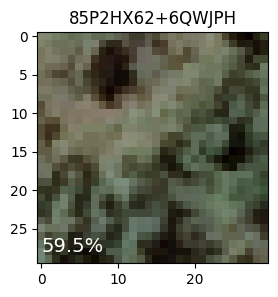

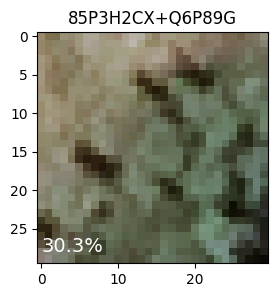

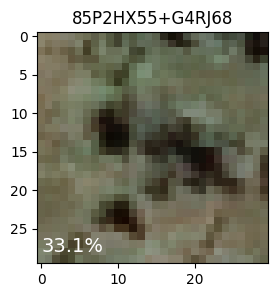

In [13]:
import matplotlib.pyplot as plt


for _, footprint in samples.sample(n=3).iterrows():
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(footprint.image.reshape(*FOOTPRINT_SIZE, len(BANDS))[..., :3])
    ax.set_title(footprint.id)
    ax.text(0, 28, f"{footprint.cancov:.1f}%", fontdict=dict(color="white", size=14))

## Export

The final step is to export our sampled footprints so that we can access them during training. We'll store them in a [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) format, which allows similar compression to TFRecords with the accessibility of CSVs.

In [14]:
import h5py
import numpy as np

out_name = f"malheur_{N_SAMPLES}_{FOOTPRINT_SIZE[0]}x{FOOTPRINT_SIZE[1]}_{NAIP_YEAR}"

with h5py.File(f"../data/{out_name}.h5", "w") as f:
    f.create_dataset(name="image", data=np.stack(samples.image), compression="gzip")
    f.create_dataset(name="cancov", data=samples.cancov.values, compression="gzip")